# Doodle Dash: Fine-Tuning Vision Transformers for Image Classification


This notebook forms part of the "Making ML-powered web games with Transformers.js" [blog post](https://huggingface.co/blog/ml-web-games), and shows how we finetuned a [MobileViT model](https://huggingface.co/Xenova/quickdraw-mobilevit-small) to be able to perform sketch classification.

Before we get started, make sure you have the necessary packages installed:

In [ ]:
!pip -q install accelerate datasets evaluate transformers[torch]

## Dataset Preparation

As mentioned in the blog post, we will use a [subset](https://huggingface.co/datasets/Xenova/quickdraw-small) of Google's [Quick, Draw!](https://quickdraw.withgoogle.com/data) dataset. This smaller dataset contains over 5 million images from 345 classes, and will be more than enough data to train our (relatively small) model.

In [2]:
from datasets import load_dataset
dataset = load_dataset('Xenova/quickdraw-small')
dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/4500000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/250000 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/250000 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Xenova___parquet/Xenova--quickdraw-small-1594d25b48b115ad/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4500000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 250000
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 250000
    })
})

Just to make sure everything's working correctly, let's take a look at one of the training images!

octopus


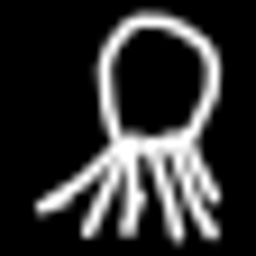

In [3]:
example = dataset['train'][1]
dataset_class_names = dataset['train'].features['label'].names

print(dataset_class_names[example['label']])
example['image'].resize((256, 256))

Sure, I guess that looks like an "octopus"? 👀 *(I only count 6 legs though, so, perhaps more like a "hexapus"?)*


Next up, let's create an image processor which will be used by the model to convert the raw images into a format the model can understand. In our case, we'll convert our images into 28x28 grayscale images.

In [4]:
from transformers import MobileViTImageProcessor

processor = MobileViTImageProcessor(
    size=28,
    crop_size=28,
    do_flip_channel_order=False,
    do_convert_rgb=False,
)

We'll also define a `transform` function, which will be used to transform the batches of our dataset into the correct format. This includes taking the list of PIL images and extracting their pixel values. One important thing to note is that we have to add the channel dimension (of 1) back before running the processor.

In [5]:
import numpy as np
def transform(example_batch):
    inputs = processor([
        # [h, w] -> [c, h, w]
        # => [28, 28] -> [1, 28, 28]
        np.expand_dims(np.array(x), 0)
        for x in example_batch['image']
    ], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['label'] = example_batch['label']
    return inputs

transformed_dataset = dataset.with_transform(transform)

Taking the first 2 samples of the transformed dataset, we see that the shape is as expected!

In [6]:
transformed_dataset['train'][0:2]['pixel_values'].shape

torch.Size([2, 1, 28, 28])

## Training and Evaluation

Before we start training, let's set up our data collator and evaluation metric.



[Data collators](https://huggingface.co/docs/transformers/main_classes/data_collator) are objects that will form a batch by using a list of dataset elements as input. In our case, it's as simple as stacking the pixel values of the inputs (in the batch dimension) and creating a tensor of the labels in the batch.

In [7]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

We will use the [Accuracy](https://huggingface.co/docs/evaluate/types_of_evaluations#metrics) metric to evaluate our machine learning model. As you'd expect, this is the standard way of measuring accuracy: the number of correct predictions divided by the total number of predictions.

In [8]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

Now, we could start training a new model from scratch (starting with random weights), but a far better approach is to [finetune a pretrained model](https://huggingface.co/docs/transformers/training). In our case, we will finetune [apple/mobilevit-small](https://huggingface.co/apple/mobilevit-small), which has been pretrained on ImageNet-1k. This will greatly reduce up our training times, as the pretrained model already has learnt some important concepts which can be used to classify other types of images (like edge detection). We can do this using `MobileViTForImageClassification.from_pretrained`, and then specifying some of our custom settings.

In [9]:
from transformers import MobileViTForImageClassification

labels = transformed_dataset['train'].features['label'].names

model = MobileViTForImageClassification.from_pretrained(
    'apple/mobilevit-small',
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True,
    num_channels=1,
    image_size=28,
)

Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- mobilevit.conv_stem.convolution.weight: found shape torch.Size([16, 3, 3, 3]) in the checkpoint and torch.Size([16, 1, 3, 3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([345, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([345]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We can specify the parameters to use for training using the `TrainingArguments` dataclass. Feel free to adjust the settings to your liking: you can find the list [here](https://huggingface.co/docs/transformers/v4.30.0/en/main_classes/trainer#transformers.TrainingArguments).

In [10]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./results/",
  per_device_train_batch_size=256,
  per_device_eval_batch_size=256,
  evaluation_strategy="steps",
  logging_strategy="steps",
  num_train_epochs=5,
  fp16=True,
  save_steps=5000,
  eval_steps=5000,
  logging_steps=1000,
  learning_rate=8e-4,
  save_total_limit=3,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='none',
  dataloader_num_workers=2,
)


We can now create a new `Trainer` object, which will contain everything we just created:

In [11]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=transformed_dataset["train"],
    eval_dataset=transformed_dataset["valid"],
    tokenizer=processor,
)


... and finally, we can start training! Go grab a cup of coffee... you've earned it! I'll see you in a couple of hours...

In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Once the model has finished training, we can evaluate it on both the validation and test set:

In [ ]:
metrics = trainer.evaluate(transformed_dataset['test'])
trainer.log_metrics("test", metrics)
trainer.save_metrics("test", metrics)

If you want, you can upload your model to the Hugging Face Hub. Note that in order to push to the hub, you must have git-lfs installed and be logged into your Hugging Face account (which can be done via `huggingface-cli login`).

In [ ]:
trainer.push_to_hub('doodle-dash')

This creates a repository under your username with the model name `doodle-dash`. Users can now load your model with the `from_pretrained` function:

In [16]:
from transformers import AutoModelForImageClassification
classifier = AutoModelForImageClassification.from_pretrained("Xenova/quickdraw-mobilevit-small")
classifier

MobileViTForImageClassification(
  (mobilevit): MobileViTModel(
    (conv_stem): MobileViTConvLayer(
      (convolution): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (normalization): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SiLUActivation()
    )
    (encoder): MobileViTEncoder(
      (layer): ModuleList(
        (0): MobileViTMobileNetLayer(
          (layer): ModuleList(
            (0): MobileViTInvertedResidual(
              (expand_1x1): MobileViTConvLayer(
                (convolution): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (activation): SiLUActivation()
              )
              (conv_3x3): MobileViTConvLayer(
                (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)